In [1]:
import numpy as np      #import thư viện numpy
import pandas as pd     #import thư viện pandas
from pandas.plotting import autocorrelation_plot as auto_corr

# import thư viện để vẽ biểu đồ
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

#Import thư viện để xử lý ngày giờ
import math
from datetime import datetime
from datetime import timedelta

# Import những thư viện cần thiết khác
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.options.display.max_columns=100 # to see columns 

In [3]:
df = pd.read_csv('./walmart_sales.csv')

1. Random Forest Regression

In [4]:
features = df.drop('Weekly_Sales', axis = 1)
features = features.drop(['Date'], axis=1)
labels = df['Weekly_Sales']

In [5]:
def wmae_test(test, pred): # WMAE for test 
    weights = x_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [6]:
x_train=features[:int(0.7*(len(df)))] 
x_test= features[int(0.7*(len(df))):] 
y_train=labels[:int(0.7*(len(df)))] 
y_test= labels[int(0.7*(len(df))):]

In [7]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1,
     max_depth=35, max_features = 'sqrt',min_samples_split = 10)
scaler = RobustScaler()

pipe = make_pipeline(scaler,rf)

pipe.fit(x_train, y_train)

y_pred_test = pipe.predict(x_test)

In [8]:
pipe.score(x_test,y_test)

0.6255968369616652

In [9]:
wmae_test(y_test, y_pred_test)

8394.024017786653

TH1: Heat Map only

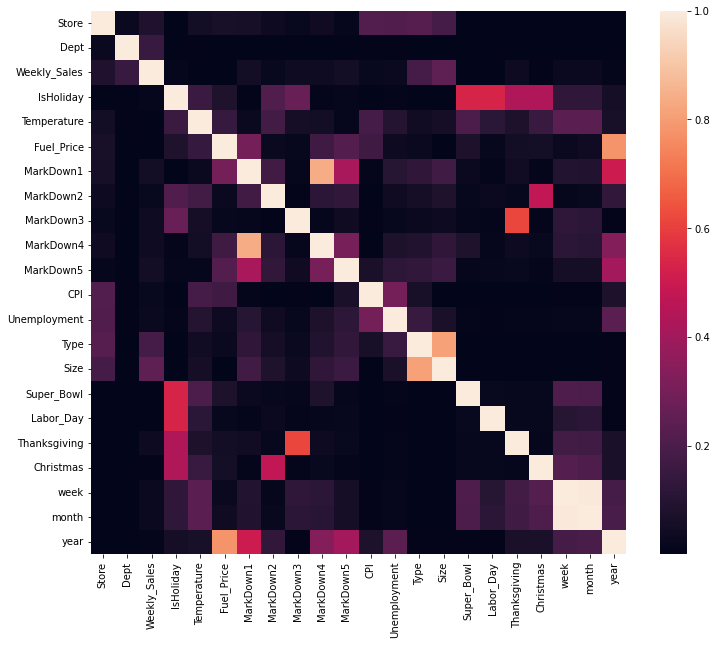

In [10]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr().abs())    
plt.show()

In [11]:
drop_col = ['Fuel_Price','Temperature','Super_Bowl','Labor_Day','Christmas']
features.drop(drop_col, axis=1, inplace=True)

x_train=features[:int(0.7*(len(df)))] 
x_test= features[int(0.7*(len(df))):] 
y_train=labels[:int(0.7*(len(df)))] 
y_test= labels[int(0.7*(len(df))):] 

In [12]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1,
     max_depth=35, max_features = 'sqrt',min_samples_split = 10)
scaler = RobustScaler()

pipe = make_pipeline(scaler,rf)

pipe.fit(x_train, y_train)

y_pred_test = pipe.predict(x_test)

In [13]:
pipe.score(x_test,y_test)

0.6881365700732048

In [14]:
wmae_test(y_test, y_pred_test)

7597.29835131824

TH2: Heat Map + Feature importances selection

Feature ranking:
1. feature 1 (0.732866)
2. feature 11 (0.096102)
3. feature 10 (0.040376)
4. feature 0 (0.033876)
5. feature 8 (0.032382)
6. feature 9 (0.017701)
7. feature 13 (0.016741)
8. feature 14 (0.007133)
9. feature 5 (0.004795)
10. feature 7 (0.003851)
11. feature 6 (0.003436)
12. feature 3 (0.003371)
13. feature 4 (0.002652)
14. feature 12 (0.001821)
15. feature 2 (0.001562)
16. feature 15 (0.001336)


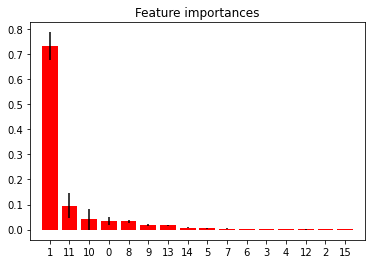

In [15]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(features.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(features.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(features.shape[1]), indices)
plt.xlim([-1, features.shape[1]])
plt.show()


In [16]:
drop_col = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Thanksgiving','year']
features.drop(drop_col, axis=1, inplace=True)

x_train=features[:int(0.7*(len(df)))] 
x_test= features[int(0.7*(len(df))):] 
y_train=labels[:int(0.7*(len(df)))] 
y_test= labels[int(0.7*(len(df))):] 

In [17]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, 
    max_depth=35, max_features = 'sqrt',min_samples_split = 10)

scaler = RobustScaler()

pipe = make_pipeline(scaler,rf)

pipe.fit(x_train, y_train)

y_pred_test = pipe.predict(x_test)

In [18]:
pipe.score(x_test,y_test)

0.7372161140265798

In [19]:
wmae_test(y_test, y_pred_test)

6888.985488108875

2. Time series model

In [20]:
df.head()

Date  Store  Dept  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0  2010-02-05      1     1      24924.50          0        42.31       2.572   
1  2010-02-05      1     2      50605.27          0        42.31       2.572   
2  2010-02-05      1     3      13740.12          0        42.31       2.572   
3  2010-02-05      1     4      39954.04          0        42.31       2.572   
4  2010-02-05      1     5      32229.38          0        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.096358   
2        0.0        0.0        0.0        0.0        0.0  211.096358   
3        0.0        0.0        0.0        0.0        0.0  211.096358   
4        0.0        0.0        0.0        0.0        0.0  211.096358   

   Unemployment  Type    Size  Super_Bowl  Labor_Day  Thanksgiving  Christmas  \
0         8.106     1  151315           0          0             0          0   
1         8.106     1  151315           0          0             0          0   
2         8.106     1  151315           0          0             0          0   
3         8.106     1  151315           0          0             0          0   
4         8.106     1  151315           0          0             0          0   

   week  month  year  
0     5      2  2010  
1     5      2  2010  
2     5      2  2010  
3     5      2  2010  
4     5      2  2010

In [21]:
df["Date"] = pd.to_datetime(df["Date"]) 

In [22]:
df.set_index('Date', inplace=True) 

In [23]:
df= df.resample('W').mean()

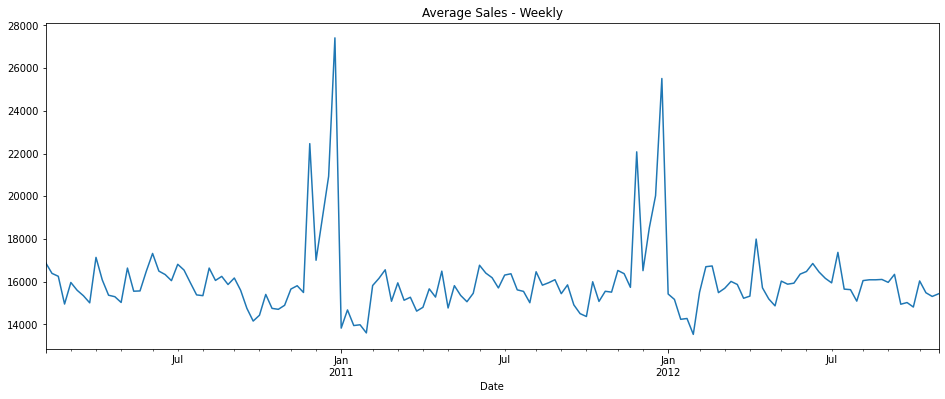

In [24]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [25]:
ts_features = df.drop('Weekly_Sales', axis = 1)
ts_labels = df['Weekly_Sales']

In [26]:
x_train=ts_features[:int(0.7*(len(df)))] 
x_test= ts_features[int(0.7*(len(df))):] 
y_train=ts_labels[:int(0.7*(len(df)))] 
y_test= ts_labels[int(0.7*(len(df))):]

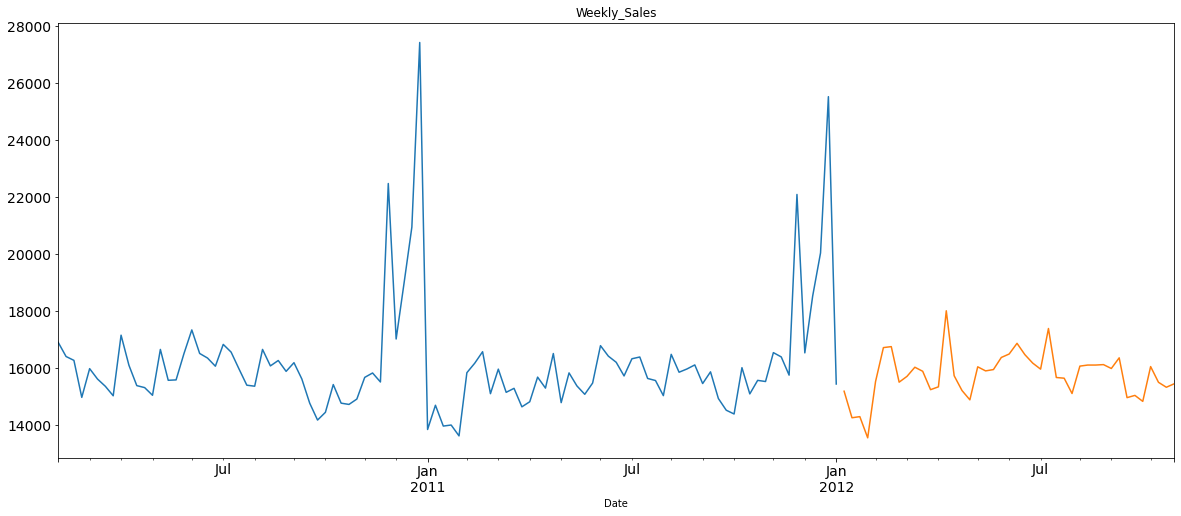

In [27]:
y_train.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
y_test.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [28]:
decomposed = decompose(df['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data 

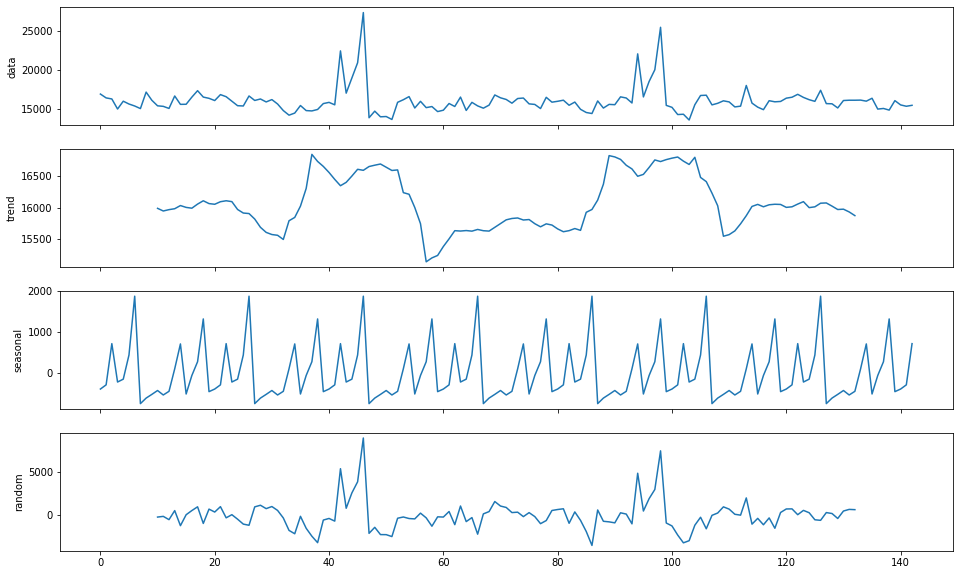

In [29]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})

In [30]:
def result(timeseries):    
    #Determine rolling statistics
    roll_mean = timeseries.rolling(window=2).mean()
    roll_std = timeseries.rolling(window=2).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

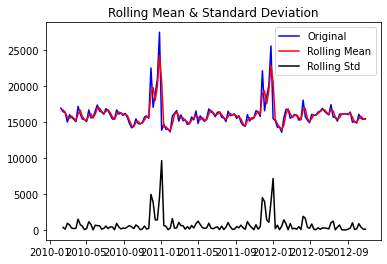

Results of Dickey Fuller Test:
Test Statistic                -5.927107e+00
p-value                        2.429049e-07
#Lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [31]:
result(df['Weekly_Sales'])

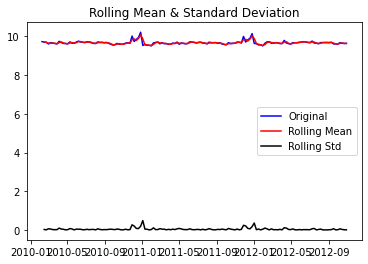

Results of Dickey Fuller Test:
Test Statistic                -6.348405e+00
p-value                        2.647711e-08
#Lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [32]:
df_log = np.log(df['Weekly_Sales']).dropna()
result(df_log)

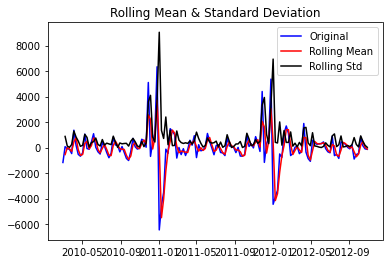

Results of Dickey Fuller Test:
Test Statistic                -6.156235e+00
p-value                        7.357088e-08
#Lags Used                     7.000000e+00
Number of Observations Used    1.320000e+02
Critical Value (1%)           -3.480888e+00
Critical Value (5%)           -2.883697e+00
Critical Value (10%)          -2.578586e+00
dtype: float64


In [33]:
roll_mean = df['Weekly_Sales'].rolling(window=4).mean()
df_mean=(df['Weekly_Sales'] - roll_mean).dropna()
result(df_mean)

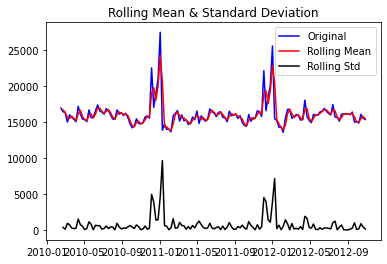

Results of Dickey Fuller Test:
Test Statistic                -5.908979e+00
p-value                        2.666619e-07
#Lags Used                     4.000000e+00
Number of Observations Used    1.370000e+02
Critical Value (1%)           -3.479007e+00
Critical Value (5%)           -2.882878e+00
Critical Value (10%)          -2.578149e+00
dtype: float64


In [34]:
df_shift =df['Weekly_Sales'].shift().dropna()
result(df_shift)

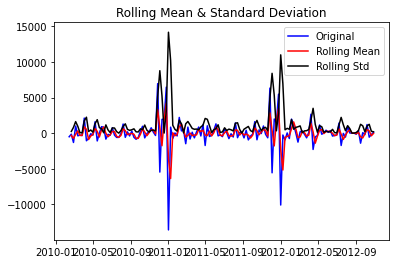

Results of Dickey Fuller Test:
Test Statistic                -6.674884e+00
p-value                        4.491230e-09
#Lags Used                     7.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


In [35]:
df_diff = df['Weekly_Sales'].diff().dropna()
result(df_diff)

In [36]:
train =df_diff [:int(0.7*(len(df)))]
test = df_diff [int(0.7*(len(df))):]

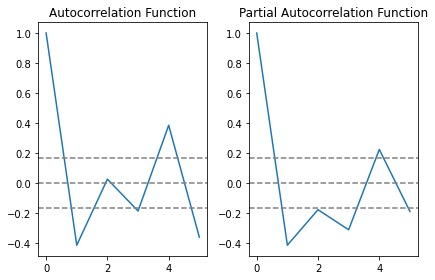

In [37]:
#ACF & PACF plots
lag_acf = acf(df_diff, nlags=5)
lag_pacf = pacf(df_diff, nlags=5, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()    

Text(0.5, 1.0, 'RSS: 503752813.9838')

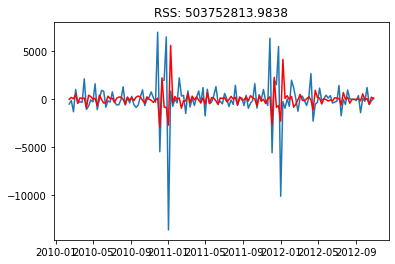

In [38]:
#AR model
model = ARIMA(df_diff, order=(1,0,0))
results_AR= model.fit()
plt.plot(df_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_diff)**2))

Text(0.5, 1.0, 'RSS: 460750244.7353')

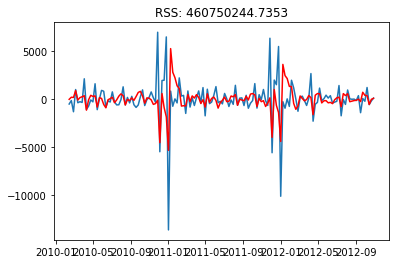

In [39]:
#MA model
model = ARIMA(df_diff, order=(0,0,1))
results_MA= model.fit()
plt.plot(df_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - df_diff)**2))

Text(0.5, 1.0, 'RSS: 412538411.8863')

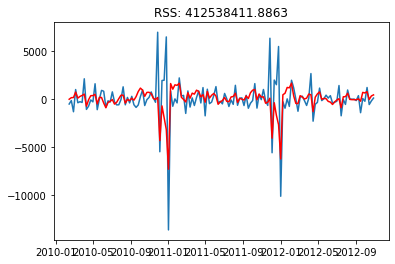

In [40]:
# AR+I+MA = ARIMA model
model = ARIMA(df_diff, order=(1,0,1))
results_ARIMA= model.fit()
plt.plot(df_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_diff)**2))

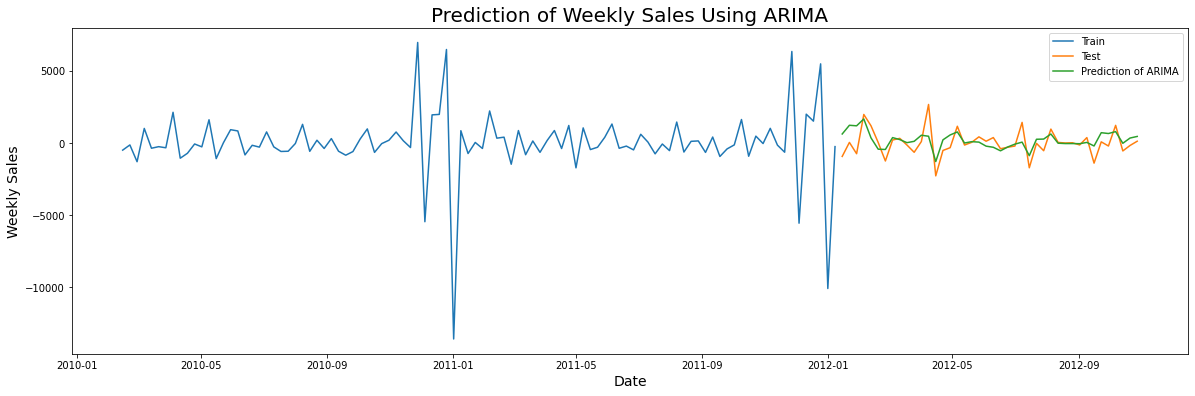

In [41]:
y_pred = results_ARIMA.predict(n_periods=len(test))
y_pred = pd.DataFrame(y_pred,index = test.index,columns=['predicted_mean'])
y_pred_series=y_pred.squeeze()
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using ARIMA', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [42]:
wmae_test(test, y_pred_series)

572.0450766355203

In [43]:
print(metrics.mean_squared_error(test,y_pred))
print(metrics.mean_absolute_error(test,y_pred))

597574.1455512869
582.926511355684


In [44]:
model_auto_arima = auto_arima(train, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0, 
        max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
        information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
        error_action='ignore',approximation = False)
model_auto_arima.fit(train)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1844.276, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1814.418, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1826.564, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1823.353, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1811.713, Time=0.08 sec

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

Text(0.5, 1.0, 'RSS: 396589663.7139')

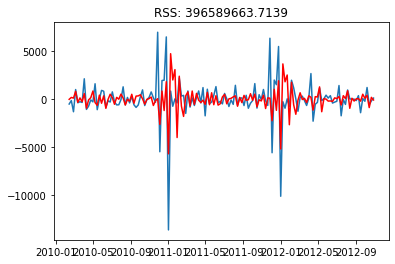

In [45]:
model = ARIMA(df_diff, order=(3,0,2))
results_ARIMA= model.fit()
plt.plot(df_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_diff)**2))

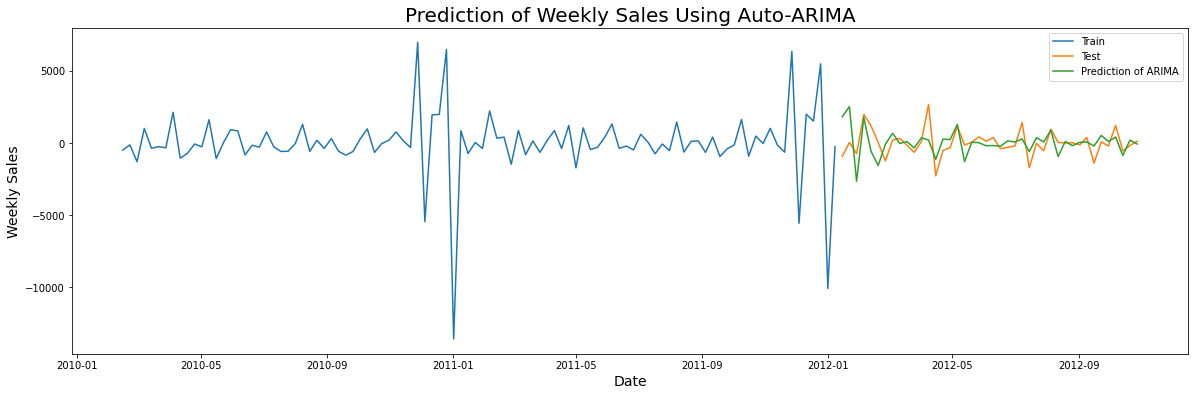

In [46]:
y_pred = results_ARIMA.predict(n_periods=len(test))
y_pred = pd.DataFrame(y_pred,index = test.index,columns=['predicted_mean'])
y_pred_series=y_pred.squeeze()
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [47]:
wmae_test(test, y_pred_series)

763.9384319960819

In [48]:
print(metrics.mean_squared_error(test,y_pred))
print(metrics.mean_absolute_error(test,y_pred))

1008398.5638434644
729.9107963181262
